In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 9iotn5sk


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-9iotn5sk:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.4


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_rcn = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_rcn = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_rcn = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_rcn = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_rcn = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                                            | 0/5867 [00:00<?, ?it/s]

  0%|                                                                                                                                                  | 1/5867 [00:00<1:01:53,  1.58it/s]

  0%|▏                                                                                                                                                   | 9/5867 [00:00<06:08, 15.88it/s]

  0%|▍                                                                                                                                                  | 17/5867 [00:00<03:21, 28.99it/s]

  0%|▋                                                                                                                                                  | 25/5867 [00:00<02:25, 40.28it/s]

  1%|▊                                                                                                                                                  | 33/5867 [00:01<01:57, 49.53it/s]

  1%|█                                                                                                                                                  | 41/5867 [00:01<01:42, 56.78it/s]

  1%|█▏                                                                                                                                                 | 49/5867 [00:01<01:33, 62.25it/s]

  1%|█▍                                                                                                                                                 | 57/5867 [00:01<01:27, 66.44it/s]

  1%|█▋                                                                                                                                                 | 65/5867 [00:01<01:23, 69.57it/s]

  1%|█▊                                                                                                                                                 | 73/5867 [00:01<01:20, 71.85it/s]

  1%|██                                                                                                                                                 | 81/5867 [00:01<01:18, 73.44it/s]

  2%|██▏                                                                                                                                                | 89/5867 [00:01<01:17, 74.63it/s]

  2%|██▍                                                                                                                                                | 97/5867 [00:01<01:16, 75.35it/s]

  2%|██▌                                                                                                                                               | 105/5867 [00:01<01:15, 75.94it/s]

  2%|██▊                                                                                                                                               | 113/5867 [00:02<01:15, 76.37it/s]

  2%|███                                                                                                                                               | 121/5867 [00:02<01:14, 76.78it/s]

  2%|███▏                                                                                                                                              | 129/5867 [00:02<01:14, 77.06it/s]

  2%|███▍                                                                                                                                              | 137/5867 [00:02<01:14, 77.15it/s]

  2%|███▌                                                                                                                                              | 145/5867 [00:02<01:14, 77.27it/s]

  3%|███▊                                                                                                                                              | 153/5867 [00:02<01:13, 77.34it/s]

  3%|████                                                                                                                                              | 161/5867 [00:02<01:13, 77.43it/s]

  3%|████▏                                                                                                                                             | 169/5867 [00:02<01:13, 77.45it/s]

  3%|████▍                                                                                                                                             | 177/5867 [00:02<01:13, 77.35it/s]

  3%|████▌                                                                                                                                             | 185/5867 [00:03<01:13, 77.37it/s]

  3%|████▊                                                                                                                                             | 193/5867 [00:03<01:13, 77.47it/s]

  3%|█████                                                                                                                                             | 201/5867 [00:03<01:13, 77.49it/s]

  4%|█████▏                                                                                                                                            | 209/5867 [00:03<01:13, 77.47it/s]

  4%|█████▍                                                                                                                                            | 217/5867 [00:03<01:12, 77.53it/s]

  4%|█████▌                                                                                                                                            | 225/5867 [00:03<01:12, 77.41it/s]

  4%|█████▊                                                                                                                                            | 233/5867 [00:03<01:12, 77.41it/s]

  4%|█████▉                                                                                                                                            | 241/5867 [00:03<01:12, 77.28it/s]

  4%|██████▏                                                                                                                                           | 249/5867 [00:03<01:12, 77.24it/s]

  4%|██████▍                                                                                                                                           | 257/5867 [00:03<01:12, 77.12it/s]

  5%|██████▌                                                                                                                                           | 265/5867 [00:04<01:12, 77.29it/s]

  5%|██████▊                                                                                                                                           | 273/5867 [00:04<01:12, 77.44it/s]

  5%|██████▉                                                                                                                                           | 281/5867 [00:04<01:12, 77.53it/s]

  5%|███████▏                                                                                                                                          | 289/5867 [00:04<01:12, 77.13it/s]

  5%|███████▍                                                                                                                                          | 297/5867 [00:04<01:12, 77.18it/s]

  5%|███████▌                                                                                                                                          | 305/5867 [00:04<01:11, 77.36it/s]

  5%|███████▊                                                                                                                                          | 313/5867 [00:04<01:11, 77.44it/s]

  5%|███████▉                                                                                                                                          | 321/5867 [00:04<01:11, 77.50it/s]

  6%|████████▏                                                                                                                                         | 329/5867 [00:04<01:11, 77.58it/s]

  6%|████████▍                                                                                                                                         | 337/5867 [00:04<01:11, 77.61it/s]

  6%|████████▌                                                                                                                                         | 345/5867 [00:05<01:11, 77.61it/s]

  6%|████████▊                                                                                                                                         | 353/5867 [00:05<01:11, 77.53it/s]

  6%|████████▉                                                                                                                                         | 361/5867 [00:05<01:11, 77.51it/s]

  6%|█████████▏                                                                                                                                        | 369/5867 [00:05<01:10, 77.53it/s]

  6%|█████████▍                                                                                                                                        | 377/5867 [00:05<01:10, 77.57it/s]

  7%|█████████▌                                                                                                                                        | 385/5867 [00:05<01:10, 77.56it/s]

  7%|█████████▊                                                                                                                                        | 393/5867 [00:05<01:10, 77.58it/s]

  7%|█████████▉                                                                                                                                        | 401/5867 [00:05<01:10, 77.24it/s]

  7%|██████████▏                                                                                                                                       | 409/5867 [00:05<01:10, 77.04it/s]

  7%|██████████▍                                                                                                                                       | 417/5867 [00:06<01:10, 77.10it/s]

  7%|██████████▌                                                                                                                                       | 425/5867 [00:06<01:10, 77.22it/s]

  7%|██████████▊                                                                                                                                       | 433/5867 [00:06<01:10, 77.34it/s]

  8%|██████████▉                                                                                                                                       | 441/5867 [00:06<01:10, 77.36it/s]

  8%|███████████▏                                                                                                                                      | 449/5867 [00:06<01:09, 77.42it/s]

  8%|███████████▎                                                                                                                                      | 457/5867 [00:06<01:10, 77.20it/s]

  8%|███████████▌                                                                                                                                      | 465/5867 [00:06<01:10, 77.08it/s]

  8%|███████████▊                                                                                                                                      | 473/5867 [00:06<01:09, 77.26it/s]

  8%|███████████▉                                                                                                                                      | 481/5867 [00:06<01:09, 77.31it/s]

  8%|████████████▏                                                                                                                                     | 489/5867 [00:06<01:09, 77.34it/s]

  8%|████████████▎                                                                                                                                     | 497/5867 [00:07<01:09, 77.41it/s]

  9%|████████████▌                                                                                                                                     | 505/5867 [00:07<01:09, 77.48it/s]

  9%|████████████▊                                                                                                                                     | 513/5867 [00:07<01:09, 77.33it/s]

  9%|████████████▉                                                                                                                                     | 521/5867 [00:07<01:09, 77.46it/s]

  9%|█████████████▏                                                                                                                                    | 529/5867 [00:07<01:08, 77.47it/s]

  9%|█████████████▎                                                                                                                                    | 537/5867 [00:07<01:08, 77.54it/s]

  9%|█████████████▌                                                                                                                                    | 545/5867 [00:07<01:08, 77.47it/s]

  9%|█████████████▊                                                                                                                                    | 553/5867 [00:07<01:08, 77.54it/s]

 10%|█████████████▉                                                                                                                                    | 561/5867 [00:07<01:08, 77.57it/s]

 10%|██████████████▏                                                                                                                                   | 569/5867 [00:07<01:08, 77.61it/s]

 10%|██████████████▎                                                                                                                                   | 577/5867 [00:08<01:08, 77.42it/s]

 10%|██████████████▌                                                                                                                                   | 585/5867 [00:08<01:08, 77.48it/s]

 10%|██████████████▊                                                                                                                                   | 593/5867 [00:08<01:08, 77.51it/s]

 10%|██████████████▉                                                                                                                                   | 601/5867 [00:08<01:07, 77.52it/s]

 10%|███████████████▏                                                                                                                                  | 609/5867 [00:08<01:07, 77.54it/s]

 11%|███████████████▎                                                                                                                                  | 617/5867 [00:08<01:07, 77.45it/s]

 11%|███████████████▌                                                                                                                                  | 625/5867 [00:08<01:07, 77.49it/s]

 11%|███████████████▊                                                                                                                                  | 633/5867 [00:08<01:07, 77.52it/s]

 11%|███████████████▉                                                                                                                                  | 641/5867 [00:08<01:07, 77.58it/s]

 11%|████████████████▏                                                                                                                                 | 649/5867 [00:09<01:07, 77.43it/s]

 11%|████████████████▎                                                                                                                                 | 657/5867 [00:09<01:07, 77.60it/s]

 11%|████████████████▌                                                                                                                                 | 665/5867 [00:09<01:07, 77.50it/s]

 11%|████████████████▋                                                                                                                                 | 673/5867 [00:09<01:07, 77.51it/s]

 12%|████████████████▉                                                                                                                                 | 681/5867 [00:09<01:07, 77.13it/s]

 12%|█████████████████▏                                                                                                                                | 689/5867 [00:09<01:06, 77.30it/s]

 12%|█████████████████▎                                                                                                                                | 697/5867 [00:09<01:06, 77.39it/s]

 12%|█████████████████▌                                                                                                                                | 705/5867 [00:09<01:06, 77.50it/s]

 12%|█████████████████▋                                                                                                                                | 713/5867 [00:09<01:06, 77.53it/s]

 12%|█████████████████▉                                                                                                                                | 721/5867 [00:09<01:06, 77.50it/s]

 12%|██████████████████▏                                                                                                                               | 729/5867 [00:10<01:06, 77.45it/s]

 13%|██████████████████▎                                                                                                                               | 737/5867 [00:10<01:06, 77.61it/s]

 13%|██████████████████▌                                                                                                                               | 745/5867 [00:10<01:06, 77.55it/s]

 13%|██████████████████▋                                                                                                                               | 753/5867 [00:10<01:05, 77.50it/s]

 13%|██████████████████▉                                                                                                                               | 761/5867 [00:10<01:05, 77.52it/s]

 13%|███████████████████▏                                                                                                                              | 769/5867 [00:10<01:05, 77.58it/s]

 13%|███████████████████▎                                                                                                                              | 777/5867 [00:10<01:05, 77.62it/s]

 13%|███████████████████▌                                                                                                                              | 785/5867 [00:10<01:05, 77.63it/s]

 14%|███████████████████▋                                                                                                                              | 793/5867 [00:10<01:05, 77.64it/s]

 14%|███████████████████▉                                                                                                                              | 801/5867 [00:10<01:05, 77.65it/s]

 14%|████████████████████▏                                                                                                                             | 809/5867 [00:11<01:05, 77.58it/s]

 14%|████████████████████▎                                                                                                                             | 817/5867 [00:11<01:05, 77.58it/s]

 14%|████████████████████▌                                                                                                                             | 825/5867 [00:11<01:05, 77.52it/s]

 14%|████████████████████▋                                                                                                                             | 833/5867 [00:11<01:04, 77.53it/s]

 14%|████████████████████▉                                                                                                                             | 841/5867 [00:11<01:04, 77.59it/s]

 14%|█████████████████████▏                                                                                                                            | 849/5867 [00:11<01:04, 77.61it/s]

 15%|█████████████████████▎                                                                                                                            | 857/5867 [00:11<01:04, 77.63it/s]

 15%|█████████████████████▌                                                                                                                            | 865/5867 [00:11<01:04, 77.65it/s]

 15%|█████████████████████▋                                                                                                                            | 873/5867 [00:11<01:04, 77.55it/s]

 15%|█████████████████████▉                                                                                                                            | 881/5867 [00:11<01:04, 77.54it/s]

 15%|██████████████████████                                                                                                                            | 889/5867 [00:12<01:04, 77.55it/s]

 15%|██████████████████████▎                                                                                                                           | 897/5867 [00:12<01:04, 77.59it/s]

 15%|██████████████████████▌                                                                                                                           | 905/5867 [00:12<01:03, 77.61it/s]

 16%|██████████████████████▋                                                                                                                           | 913/5867 [00:12<01:03, 77.59it/s]

 16%|██████████████████████▉                                                                                                                           | 921/5867 [00:12<01:03, 77.45it/s]

 16%|███████████████████████                                                                                                                           | 929/5867 [00:12<01:04, 76.78it/s]

 16%|███████████████████████▎                                                                                                                          | 937/5867 [00:12<01:04, 76.30it/s]

 16%|███████████████████████▌                                                                                                                          | 945/5867 [00:12<01:04, 75.96it/s]

 16%|███████████████████████▋                                                                                                                          | 953/5867 [00:12<01:04, 75.72it/s]

 16%|███████████████████████▉                                                                                                                          | 961/5867 [00:13<01:04, 75.56it/s]

 17%|████████████████████████                                                                                                                          | 969/5867 [00:13<01:05, 75.31it/s]

 17%|████████████████████████▎                                                                                                                         | 977/5867 [00:13<01:05, 74.87it/s]

 17%|████████████████████████▌                                                                                                                         | 985/5867 [00:13<01:05, 74.97it/s]

 17%|████████████████████████▋                                                                                                                         | 993/5867 [00:13<01:04, 75.06it/s]

 17%|████████████████████████▋                                                                                                                        | 1001/5867 [00:13<01:04, 75.04it/s]

 17%|████████████████████████▉                                                                                                                        | 1009/5867 [00:13<01:04, 75.10it/s]

 17%|█████████████████████████▏                                                                                                                       | 1017/5867 [00:13<01:04, 75.15it/s]

 17%|█████████████████████████▎                                                                                                                       | 1025/5867 [00:13<01:04, 75.12it/s]

 18%|█████████████████████████▌                                                                                                                       | 1033/5867 [00:14<01:04, 75.13it/s]

 18%|█████████████████████████▋                                                                                                                       | 1041/5867 [00:14<01:04, 74.81it/s]

 18%|█████████████████████████▉                                                                                                                       | 1049/5867 [00:14<01:04, 74.94it/s]

 18%|██████████████████████████                                                                                                                       | 1057/5867 [00:14<01:04, 74.99it/s]

 18%|██████████████████████████▎                                                                                                                      | 1065/5867 [00:14<01:04, 75.01it/s]

 18%|██████████████████████████▌                                                                                                                      | 1073/5867 [00:14<01:04, 74.59it/s]

 18%|██████████████████████████▋                                                                                                                      | 1081/5867 [00:14<01:04, 74.68it/s]

 19%|██████████████████████████▉                                                                                                                      | 1089/5867 [00:14<01:03, 74.76it/s]

 19%|███████████████████████████                                                                                                                      | 1097/5867 [00:14<01:03, 74.72it/s]

 19%|███████████████████████████▎                                                                                                                     | 1105/5867 [00:14<01:03, 74.61it/s]

 19%|███████████████████████████▌                                                                                                                     | 1113/5867 [00:15<01:03, 74.55it/s]

 19%|███████████████████████████▋                                                                                                                     | 1121/5867 [00:15<01:03, 74.52it/s]

 19%|███████████████████████████▉                                                                                                                     | 1129/5867 [00:15<01:03, 74.46it/s]

 19%|████████████████████████████                                                                                                                     | 1137/5867 [00:15<01:03, 74.44it/s]

 20%|████████████████████████████▎                                                                                                                    | 1145/5867 [00:15<01:03, 74.44it/s]

 20%|████████████████████████████▍                                                                                                                    | 1153/5867 [00:15<01:03, 74.45it/s]

 20%|████████████████████████████▋                                                                                                                    | 1161/5867 [00:15<01:03, 74.42it/s]

 20%|████████████████████████████▉                                                                                                                    | 1169/5867 [00:15<01:03, 74.32it/s]

 20%|█████████████████████████████                                                                                                                    | 1177/5867 [00:15<01:03, 74.40it/s]

 20%|█████████████████████████████▎                                                                                                                   | 1185/5867 [00:16<01:02, 74.38it/s]

 20%|█████████████████████████████▍                                                                                                                   | 1193/5867 [00:16<01:02, 74.51it/s]

 20%|█████████████████████████████▋                                                                                                                   | 1201/5867 [00:16<01:02, 74.58it/s]

 21%|█████████████████████████████▉                                                                                                                   | 1209/5867 [00:16<01:02, 74.54it/s]

 21%|██████████████████████████████                                                                                                                   | 1217/5867 [00:16<01:02, 74.56it/s]

 21%|██████████████████████████████▎                                                                                                                  | 1225/5867 [00:16<01:02, 74.63it/s]

 21%|██████████████████████████████▍                                                                                                                  | 1233/5867 [00:16<01:02, 74.67it/s]

 21%|██████████████████████████████▋                                                                                                                  | 1241/5867 [00:16<01:02, 74.57it/s]

 21%|██████████████████████████████▊                                                                                                                  | 1249/5867 [00:16<01:01, 74.55it/s]

 21%|███████████████████████████████                                                                                                                  | 1257/5867 [00:17<01:01, 74.52it/s]

 22%|███████████████████████████████▎                                                                                                                 | 1265/5867 [00:17<01:01, 74.53it/s]

 22%|███████████████████████████████▍                                                                                                                 | 1273/5867 [00:17<01:01, 74.47it/s]

 22%|███████████████████████████████▋                                                                                                                 | 1281/5867 [00:17<01:01, 74.51it/s]

 22%|███████████████████████████████▊                                                                                                                 | 1289/5867 [00:17<01:01, 74.75it/s]

 22%|████████████████████████████████                                                                                                                 | 1297/5867 [00:17<01:00, 74.93it/s]

 22%|████████████████████████████████▎                                                                                                                | 1305/5867 [00:17<01:00, 75.00it/s]

 22%|████████████████████████████████▍                                                                                                                | 1313/5867 [00:17<01:00, 75.02it/s]

 23%|████████████████████████████████▋                                                                                                                | 1321/5867 [00:17<01:00, 75.10it/s]

 23%|████████████████████████████████▊                                                                                                                | 1329/5867 [00:17<01:00, 75.24it/s]

 23%|█████████████████████████████████                                                                                                                | 1337/5867 [00:18<01:00, 75.20it/s]

 23%|█████████████████████████████████▏                                                                                                               | 1345/5867 [00:18<01:00, 75.22it/s]

 23%|█████████████████████████████████▍                                                                                                               | 1353/5867 [00:18<01:00, 75.20it/s]

 23%|█████████████████████████████████▋                                                                                                               | 1361/5867 [00:18<00:59, 75.26it/s]

 23%|█████████████████████████████████▊                                                                                                               | 1369/5867 [00:18<00:59, 75.16it/s]

 23%|██████████████████████████████████                                                                                                               | 1377/5867 [00:18<00:59, 75.13it/s]

 24%|██████████████████████████████████▏                                                                                                              | 1385/5867 [00:18<00:59, 75.10it/s]

 24%|██████████████████████████████████▍                                                                                                              | 1393/5867 [00:18<00:59, 74.99it/s]

 24%|██████████████████████████████████▋                                                                                                              | 1401/5867 [00:18<00:59, 75.04it/s]

 24%|██████████████████████████████████▊                                                                                                              | 1409/5867 [00:19<00:59, 74.94it/s]

 24%|███████████████████████████████████                                                                                                              | 1417/5867 [00:19<00:59, 74.85it/s]

 24%|███████████████████████████████████▏                                                                                                             | 1425/5867 [00:19<00:59, 74.93it/s]

 24%|███████████████████████████████████▍                                                                                                             | 1433/5867 [00:19<00:59, 75.04it/s]

 25%|███████████████████████████████████▌                                                                                                             | 1441/5867 [00:19<00:58, 75.13it/s]

 25%|███████████████████████████████████▊                                                                                                             | 1449/5867 [00:19<00:58, 74.98it/s]

 25%|████████████████████████████████████                                                                                                             | 1457/5867 [00:19<00:58, 75.05it/s]

 25%|████████████████████████████████████▏                                                                                                            | 1465/5867 [00:19<00:58, 75.09it/s]

 25%|████████████████████████████████████▍                                                                                                            | 1473/5867 [00:19<00:58, 75.11it/s]

 25%|████████████████████████████████████▌                                                                                                            | 1481/5867 [00:19<00:58, 74.98it/s]

 25%|████████████████████████████████████▊                                                                                                            | 1489/5867 [00:20<00:58, 75.05it/s]

 26%|████████████████████████████████████▉                                                                                                            | 1497/5867 [00:20<00:58, 75.07it/s]

 26%|█████████████████████████████████████▏                                                                                                           | 1505/5867 [00:20<00:58, 75.15it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 1513/5867 [00:20<00:58, 75.00it/s]

 26%|█████████████████████████████████████▌                                                                                                           | 1521/5867 [00:20<00:57, 75.14it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 1529/5867 [00:20<00:57, 75.18it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 1537/5867 [00:20<00:57, 75.25it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 1545/5867 [00:20<00:57, 75.50it/s]

 26%|██████████████████████████████████████▍                                                                                                          | 1553/5867 [00:20<00:57, 75.41it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 1561/5867 [00:21<00:57, 74.95it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 1569/5867 [00:21<00:57, 75.01it/s]

 27%|██████████████████████████████████████▉                                                                                                          | 1577/5867 [00:21<00:57, 75.10it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 1585/5867 [00:21<00:57, 75.12it/s]

 27%|███████████████████████████████████████▎                                                                                                         | 1593/5867 [00:21<00:56, 75.30it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 1601/5867 [00:21<00:56, 75.31it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 1609/5867 [00:21<00:56, 75.29it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 1617/5867 [00:21<00:56, 75.29it/s]

 28%|████████████████████████████████████████▏                                                                                                        | 1625/5867 [00:21<00:56, 75.28it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 1633/5867 [00:22<00:56, 75.30it/s]

 28%|████████████████████████████████████████▌                                                                                                        | 1641/5867 [00:22<00:56, 75.24it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 1649/5867 [00:22<00:56, 75.23it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 1657/5867 [00:22<00:55, 75.29it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 1665/5867 [00:22<00:55, 75.12it/s]

 29%|█████████████████████████████████████████▎                                                                                                       | 1673/5867 [00:22<00:55, 75.16it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 1681/5867 [00:22<00:55, 75.22it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 1689/5867 [00:22<00:55, 75.21it/s]

 29%|█████████████████████████████████████████▉                                                                                                       | 1697/5867 [00:22<00:55, 75.21it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 1705/5867 [00:22<00:55, 75.26it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 1713/5867 [00:23<00:55, 75.30it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 1721/5867 [00:23<00:55, 75.29it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 1729/5867 [00:23<00:54, 75.31it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 1737/5867 [00:23<00:54, 75.24it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 1745/5867 [00:23<00:54, 75.24it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 1753/5867 [00:23<00:54, 75.28it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 1761/5867 [00:23<00:54, 75.28it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 1769/5867 [00:23<00:54, 75.28it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 1777/5867 [00:23<00:54, 75.28it/s]

 30%|████████████████████████████████████████████                                                                                                     | 1785/5867 [00:24<00:54, 75.29it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 1793/5867 [00:24<00:54, 75.29it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 1801/5867 [00:24<00:54, 75.28it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 1809/5867 [00:24<00:53, 75.29it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 1817/5867 [00:24<00:53, 75.25it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 1825/5867 [00:24<00:53, 75.22it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 1833/5867 [00:24<00:53, 75.17it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 1841/5867 [00:24<00:53, 75.13it/s]

 32%|█████████████████████████████████████████████▋                                                                                                   | 1849/5867 [00:24<00:53, 75.22it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 1857/5867 [00:24<00:53, 75.17it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 1865/5867 [00:25<00:53, 75.14it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 1873/5867 [00:25<00:53, 74.72it/s]

 32%|██████████████████████████████████████████████▍                                                                                                  | 1881/5867 [00:25<00:52, 75.62it/s]

 32%|██████████████████████████████████████████████▋                                                                                                  | 1889/5867 [00:25<00:52, 76.26it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 1897/5867 [00:25<00:51, 76.78it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 1905/5867 [00:25<00:51, 77.09it/s]

 33%|███████████████████████████████████████████████▎                                                                                                 | 1913/5867 [00:25<00:51, 77.17it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 1921/5867 [00:25<00:51, 77.32it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 1929/5867 [00:25<00:50, 77.30it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 1937/5867 [00:26<00:50, 77.34it/s]

 33%|████████████████████████████████████████████████                                                                                                 | 1945/5867 [00:26<00:50, 77.29it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1953/5867 [00:26<00:50, 77.23it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 1961/5867 [00:26<00:50, 77.17it/s]

 34%|████████████████████████████████████████████████▋                                                                                                | 1969/5867 [00:26<00:50, 77.01it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 1977/5867 [00:26<00:50, 77.09it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 1985/5867 [00:26<00:50, 77.06it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 1993/5867 [00:26<00:50, 77.20it/s]

 34%|█████████████████████████████████████████████████▍                                                                                               | 2001/5867 [00:26<00:50, 77.30it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 2009/5867 [00:26<00:49, 77.39it/s]

 34%|█████████████████████████████████████████████████▊                                                                                               | 2017/5867 [00:27<00:49, 77.47it/s]

 35%|██████████████████████████████████████████████████                                                                                               | 2025/5867 [00:27<00:49, 77.10it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 2033/5867 [00:27<00:49, 76.91it/s]

 35%|██████████████████████████████████████████████████▍                                                                                              | 2041/5867 [00:27<00:49, 76.95it/s]

 35%|██████████████████████████████████████████████████▋                                                                                              | 2049/5867 [00:27<00:49, 77.08it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 2057/5867 [00:27<00:49, 77.20it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 2065/5867 [00:27<00:49, 77.30it/s]

 35%|███████████████████████████████████████████████████▏                                                                                             | 2073/5867 [00:27<00:49, 77.43it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 2081/5867 [00:27<00:48, 77.43it/s]

 36%|███████████████████████████████████████████████████▋                                                                                             | 2089/5867 [00:28<00:48, 77.46it/s]

 36%|███████████████████████████████████████████████████▊                                                                                             | 2097/5867 [00:28<00:48, 77.41it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 2105/5867 [00:28<00:48, 77.10it/s]

 36%|████████████████████████████████████████████████████▏                                                                                            | 2113/5867 [00:28<00:48, 76.66it/s]

 36%|████████████████████████████████████████████████████▍                                                                                            | 2121/5867 [00:28<00:49, 76.18it/s]

 36%|████████████████████████████████████████████████████▌                                                                                            | 2129/5867 [00:28<00:49, 75.85it/s]

 36%|████████████████████████████████████████████████████▊                                                                                            | 2137/5867 [00:28<00:49, 75.63it/s]

 37%|█████████████████████████████████████████████████████                                                                                            | 2145/5867 [00:28<00:49, 75.47it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 2153/5867 [00:28<00:49, 75.41it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                           | 2161/5867 [00:28<00:49, 75.34it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 2169/5867 [00:29<00:49, 75.21it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                           | 2177/5867 [00:29<00:49, 75.22it/s]

 37%|██████████████████████████████████████████████████████                                                                                           | 2185/5867 [00:29<00:48, 75.19it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                          | 2193/5867 [00:29<00:48, 75.15it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 2201/5867 [00:29<00:48, 74.99it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                          | 2209/5867 [00:29<00:48, 74.84it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                          | 2217/5867 [00:29<00:48, 74.73it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                          | 2225/5867 [00:29<00:48, 74.66it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 2233/5867 [00:29<00:48, 74.63it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                         | 2241/5867 [00:30<00:48, 74.68it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                         | 2249/5867 [00:30<00:48, 74.74it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                         | 2257/5867 [00:30<00:48, 74.78it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                         | 2265/5867 [00:30<00:48, 74.73it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                        | 2273/5867 [00:30<00:48, 74.78it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                        | 2281/5867 [00:30<00:47, 74.84it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                        | 2289/5867 [00:30<00:47, 74.90it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                        | 2297/5867 [00:30<00:47, 74.93it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                        | 2305/5867 [00:30<00:47, 75.01it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                       | 2313/5867 [00:30<00:47, 75.05it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                       | 2321/5867 [00:31<00:47, 75.07it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                       | 2329/5867 [00:31<00:47, 75.04it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                       | 2337/5867 [00:31<00:47, 75.03it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                       | 2345/5867 [00:31<00:46, 75.11it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 2353/5867 [00:31<00:46, 75.11it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                      | 2361/5867 [00:31<00:46, 75.10it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                      | 2369/5867 [00:31<00:46, 74.67it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                      | 2377/5867 [00:31<00:46, 74.98it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                      | 2385/5867 [00:31<00:46, 74.83it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                     | 2393/5867 [00:32<00:46, 74.74it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                     | 2401/5867 [00:32<00:46, 74.71it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                     | 2409/5867 [00:32<00:46, 74.79it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                     | 2417/5867 [00:32<00:46, 74.81it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                     | 2425/5867 [00:32<00:46, 74.63it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                    | 2433/5867 [00:32<00:46, 74.54it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                    | 2441/5867 [00:32<00:45, 74.51it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 2449/5867 [00:32<00:45, 74.52it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                    | 2457/5867 [00:32<00:45, 74.51it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                    | 2465/5867 [00:33<00:45, 74.52it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                    | 2473/5867 [00:33<00:45, 74.55it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                   | 2481/5867 [00:33<00:45, 74.22it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                   | 2489/5867 [00:33<00:45, 74.13it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                   | 2497/5867 [00:33<00:45, 74.24it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                   | 2505/5867 [00:33<00:45, 74.04it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                   | 2513/5867 [00:33<00:45, 74.25it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                  | 2521/5867 [00:33<00:45, 74.32it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                  | 2529/5867 [00:33<00:44, 74.40it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                  | 2537/5867 [00:33<00:44, 74.42it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 2545/5867 [00:34<00:44, 74.53it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                  | 2553/5867 [00:34<00:44, 74.72it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 2561/5867 [00:34<00:44, 74.99it/s]

 44%|███████████████████████████████████████████████████████████████▍                                                                                 | 2569/5867 [00:34<00:43, 75.07it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                 | 2577/5867 [00:34<00:43, 75.25it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                 | 2585/5867 [00:34<00:43, 75.19it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                 | 2593/5867 [00:34<00:43, 75.23it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                | 2601/5867 [00:34<00:43, 74.97it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                | 2609/5867 [00:34<00:43, 75.12it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                                | 2617/5867 [00:35<00:43, 75.07it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                | 2625/5867 [00:35<00:43, 75.13it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                | 2633/5867 [00:35<00:43, 75.14it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 2641/5867 [00:35<00:42, 75.14it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                               | 2649/5867 [00:35<00:42, 75.04it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 2657/5867 [00:35<00:42, 75.00it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                               | 2665/5867 [00:35<00:42, 75.00it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                               | 2673/5867 [00:35<00:42, 74.75it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                              | 2681/5867 [00:35<00:42, 74.77it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                              | 2689/5867 [00:36<00:42, 74.84it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 2697/5867 [00:36<00:42, 74.73it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 2705/5867 [00:36<00:42, 74.80it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                              | 2713/5867 [00:36<00:42, 74.90it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                             | 2721/5867 [00:36<00:41, 75.04it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                             | 2729/5867 [00:36<00:41, 75.12it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 2737/5867 [00:36<00:41, 75.19it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                             | 2745/5867 [00:36<00:41, 75.35it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                             | 2753/5867 [00:36<00:41, 75.35it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                            | 2761/5867 [00:36<00:41, 75.38it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                            | 2769/5867 [00:37<00:41, 75.38it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 2777/5867 [00:37<00:40, 75.38it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                            | 2785/5867 [00:37<00:40, 75.40it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                            | 2793/5867 [00:37<00:40, 75.35it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                           | 2801/5867 [00:37<00:40, 75.32it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                           | 2809/5867 [00:37<00:40, 75.26it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 2817/5867 [00:37<00:40, 75.22it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                           | 2825/5867 [00:37<00:40, 75.19it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                           | 2833/5867 [00:37<00:40, 75.20it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                          | 2841/5867 [00:38<00:40, 75.22it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 2849/5867 [00:38<00:40, 75.23it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 2857/5867 [00:38<00:40, 75.23it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                          | 2865/5867 [00:38<00:39, 75.27it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                          | 2873/5867 [00:38<00:39, 75.31it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                         | 2881/5867 [00:38<00:39, 75.24it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                         | 2889/5867 [00:38<00:39, 75.08it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 2897/5867 [00:38<00:39, 74.99it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                         | 2905/5867 [00:38<00:39, 74.75it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                         | 2913/5867 [00:38<00:39, 74.86it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 2921/5867 [00:39<00:39, 74.95it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                        | 2929/5867 [00:39<00:39, 74.99it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2937/5867 [00:39<00:39, 75.08it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                        | 2945/5867 [00:39<00:38, 75.18it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                        | 2953/5867 [00:39<00:38, 75.23it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                       | 2961/5867 [00:39<00:38, 75.22it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 2969/5867 [00:39<00:38, 75.27it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                       | 2977/5867 [00:39<00:38, 75.23it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                       | 2985/5867 [00:39<00:38, 75.24it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 2993/5867 [00:40<00:38, 75.18it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                      | 3001/5867 [00:40<00:38, 74.70it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                      | 3009/5867 [00:40<00:38, 74.91it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                      | 3017/5867 [00:40<00:37, 75.01it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                      | 3025/5867 [00:40<00:37, 75.11it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                      | 3033/5867 [00:40<00:37, 75.15it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                     | 3041/5867 [00:40<00:37, 75.18it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 3049/5867 [00:40<00:37, 75.23it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                     | 3057/5867 [00:40<00:37, 75.17it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                     | 3065/5867 [00:41<00:37, 75.15it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                     | 3073/5867 [00:41<00:37, 75.09it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 3081/5867 [00:41<00:37, 75.02it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 3089/5867 [00:41<00:37, 75.02it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 3097/5867 [00:41<00:36, 75.00it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                    | 3105/5867 [00:41<00:36, 75.01it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                    | 3113/5867 [00:41<00:36, 75.05it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 3121/5867 [00:41<00:36, 75.09it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 3129/5867 [00:41<00:36, 75.11it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                   | 3137/5867 [00:41<00:36, 75.18it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                   | 3145/5867 [00:42<00:36, 75.20it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                   | 3153/5867 [00:42<00:36, 75.17it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                   | 3161/5867 [00:42<00:36, 75.07it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 3169/5867 [00:42<00:35, 75.07it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                  | 3177/5867 [00:42<00:35, 74.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                  | 3185/5867 [00:42<00:35, 74.96it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                  | 3193/5867 [00:42<00:35, 75.04it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                  | 3201/5867 [00:42<00:35, 75.15it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 3209/5867 [00:42<00:35, 75.25it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                 | 3217/5867 [00:43<00:35, 75.29it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                 | 3225/5867 [00:43<00:35, 75.32it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                 | 3233/5867 [00:43<00:34, 75.35it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                 | 3241/5867 [00:43<00:34, 75.39it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                | 3249/5867 [00:43<00:34, 75.41it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                                | 3257/5867 [00:43<00:34, 75.44it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                                | 3265/5867 [00:43<00:34, 75.52it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                                | 3273/5867 [00:43<00:34, 75.50it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                                | 3281/5867 [00:43<00:34, 75.48it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                               | 3289/5867 [00:43<00:34, 75.47it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                               | 3297/5867 [00:44<00:34, 75.44it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                               | 3305/5867 [00:44<00:33, 75.45it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                               | 3313/5867 [00:44<00:33, 75.39it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                               | 3321/5867 [00:44<00:33, 75.20it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                              | 3329/5867 [00:44<00:33, 75.19it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                              | 3337/5867 [00:44<00:33, 75.34it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                              | 3345/5867 [00:44<00:33, 75.47it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                              | 3353/5867 [00:44<00:33, 75.45it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                              | 3361/5867 [00:44<00:33, 75.44it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                             | 3369/5867 [00:45<00:33, 75.08it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 3377/5867 [00:45<00:33, 74.57it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                             | 3385/5867 [00:45<00:33, 74.82it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                             | 3393/5867 [00:45<00:32, 75.09it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 3401/5867 [00:45<00:32, 75.37it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                            | 3409/5867 [00:45<00:32, 75.39it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                            | 3417/5867 [00:45<00:32, 75.35it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                            | 3425/5867 [00:45<00:32, 75.40it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                            | 3433/5867 [00:45<00:32, 75.37it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 3441/5867 [00:46<00:32, 75.46it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                           | 3449/5867 [00:46<00:32, 75.43it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                           | 3457/5867 [00:46<00:32, 75.07it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                           | 3465/5867 [00:46<00:31, 75.16it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                           | 3473/5867 [00:46<00:31, 75.31it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 3481/5867 [00:46<00:31, 75.33it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                          | 3489/5867 [00:46<00:31, 75.33it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                          | 3497/5867 [00:46<00:31, 75.32it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                          | 3505/5867 [00:46<00:31, 75.37it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                          | 3513/5867 [00:46<00:31, 75.34it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3521/5867 [00:47<00:31, 75.34it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                         | 3529/5867 [00:47<00:31, 75.42it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                         | 3537/5867 [00:47<00:30, 75.40it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                         | 3545/5867 [00:47<00:30, 75.37it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                         | 3553/5867 [00:47<00:30, 75.36it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 3561/5867 [00:47<00:30, 75.38it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3569/5867 [00:47<00:30, 75.36it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 3577/5867 [00:47<00:30, 75.38it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3585/5867 [00:47<00:30, 75.34it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 3593/5867 [00:48<00:30, 75.32it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 3601/5867 [00:48<00:30, 75.32it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 3609/5867 [00:48<00:29, 75.31it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3617/5867 [00:48<00:29, 75.44it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3625/5867 [00:48<00:29, 75.63it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3633/5867 [00:48<00:29, 75.66it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3641/5867 [00:48<00:29, 75.68it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3649/5867 [00:48<00:29, 75.61it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3657/5867 [00:48<00:29, 75.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3665/5867 [00:48<00:29, 75.49it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3673/5867 [00:49<00:29, 75.56it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3681/5867 [00:49<00:28, 75.52it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3689/5867 [00:49<00:28, 75.49it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3697/5867 [00:49<00:28, 75.44it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3705/5867 [00:49<00:28, 75.44it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3713/5867 [00:49<00:28, 75.44it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 3721/5867 [00:49<00:28, 75.43it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3729/5867 [00:49<00:28, 75.41it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3737/5867 [00:49<00:28, 75.42it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3745/5867 [00:50<00:28, 75.15it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3753/5867 [00:50<00:28, 75.23it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 3761/5867 [00:50<00:27, 75.22it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3769/5867 [00:50<00:27, 75.26it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3777/5867 [00:50<00:27, 75.29it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3785/5867 [00:50<00:27, 75.33it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3793/5867 [00:50<00:27, 75.30it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3801/5867 [00:50<00:27, 74.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3809/5867 [00:50<00:27, 75.12it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 3817/5867 [00:51<00:27, 75.21it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3825/5867 [00:51<00:27, 75.12it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3833/5867 [00:51<00:27, 75.02it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3841/5867 [00:51<00:27, 74.94it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3849/5867 [00:51<00:27, 74.65it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3857/5867 [00:51<00:26, 74.76it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3865/5867 [00:51<00:26, 74.82it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3873/5867 [00:51<00:26, 74.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3881/5867 [00:51<00:26, 75.00it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3889/5867 [00:51<00:26, 75.02it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3897/5867 [00:52<00:26, 75.07it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3905/5867 [00:52<00:26, 75.12it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3913/5867 [00:52<00:26, 75.11it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3921/5867 [00:52<00:25, 75.12it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3929/5867 [00:52<00:25, 75.17it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3937/5867 [00:52<00:25, 75.19it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3945/5867 [00:52<00:25, 75.31it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3953/5867 [00:52<00:25, 75.33it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3961/5867 [00:52<00:25, 75.33it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3969/5867 [00:53<00:25, 75.51it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3977/5867 [00:53<00:25, 75.48it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3985/5867 [00:53<00:24, 75.39it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3993/5867 [00:53<00:24, 75.34it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 4001/5867 [00:53<00:24, 75.35it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████                                              | 4009/5867 [00:53<00:24, 75.40it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 4017/5867 [00:53<00:24, 75.33it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 4025/5867 [00:53<00:24, 75.29it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 4033/5867 [00:53<00:24, 75.28it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 4041/5867 [00:53<00:24, 75.26it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 4049/5867 [00:54<00:24, 75.28it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 4057/5867 [00:54<00:24, 75.29it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4065/5867 [00:54<00:23, 75.29it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4073/5867 [00:54<00:23, 75.29it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 4081/5867 [00:54<00:23, 75.32it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 4089/5867 [00:54<00:23, 75.33it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 4097/5867 [00:54<00:23, 75.32it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 4105/5867 [00:54<00:23, 75.35it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 4113/5867 [00:54<00:23, 75.33it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 4121/5867 [00:55<00:23, 75.30it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 4129/5867 [00:55<00:23, 75.31it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 4137/5867 [00:55<00:23, 75.21it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 4145/5867 [00:55<00:22, 75.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 4153/5867 [00:55<00:22, 75.17it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 4161/5867 [00:55<00:22, 75.09it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 4169/5867 [00:55<00:22, 75.04it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 4177/5867 [00:55<00:22, 75.01it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 4185/5867 [00:55<00:22, 75.01it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 4193/5867 [00:56<00:22, 75.00it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 4201/5867 [00:56<00:22, 74.92it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 4209/5867 [00:56<00:22, 74.99it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 4217/5867 [00:56<00:22, 74.94it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 4225/5867 [00:56<00:22, 74.61it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 4233/5867 [00:56<00:21, 74.68it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 4241/5867 [00:56<00:21, 74.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 4249/5867 [00:56<00:21, 74.93it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 4257/5867 [00:56<00:21, 74.97it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4265/5867 [00:56<00:21, 75.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4273/5867 [00:57<00:21, 75.00it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4281/5867 [00:57<00:21, 74.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 4289/5867 [00:57<00:21, 74.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 4297/5867 [00:57<00:21, 74.37it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4305/5867 [00:57<00:20, 74.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 4313/5867 [00:57<00:20, 74.75it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 4321/5867 [00:57<00:20, 74.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 4329/5867 [00:57<00:20, 74.94it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4337/5867 [00:57<00:20, 74.97it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 4345/5867 [00:58<00:20, 75.09it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 4353/5867 [00:58<00:20, 75.23it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4361/5867 [00:58<00:20, 75.20it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4369/5867 [00:58<00:19, 75.20it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4377/5867 [00:58<00:19, 75.16it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 4385/5867 [00:58<00:19, 75.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4393/5867 [00:58<00:19, 75.13it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4401/5867 [00:58<00:19, 75.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4409/5867 [00:58<00:19, 75.11it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4417/5867 [00:58<00:19, 74.94it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4425/5867 [00:59<00:19, 75.00it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4433/5867 [00:59<00:19, 75.11it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4441/5867 [00:59<00:18, 75.09it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4449/5867 [00:59<00:18, 75.12it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4457/5867 [00:59<00:18, 75.12it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4465/5867 [00:59<00:18, 75.18it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4473/5867 [00:59<00:18, 75.29it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4481/5867 [00:59<00:18, 75.17it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4489/5867 [00:59<00:18, 75.17it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4497/5867 [01:00<00:18, 75.21it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4505/5867 [01:00<00:18, 75.10it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4513/5867 [01:00<00:18, 74.98it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4521/5867 [01:00<00:17, 74.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4529/5867 [01:00<00:17, 75.09it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4537/5867 [01:00<00:17, 75.06it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4545/5867 [01:00<00:17, 74.96it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4553/5867 [01:00<00:17, 74.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4561/5867 [01:00<00:17, 74.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4569/5867 [01:01<00:17, 75.04it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 4577/5867 [01:01<00:17, 74.97it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4585/5867 [01:01<00:17, 75.07it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4593/5867 [01:01<00:16, 74.97it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4601/5867 [01:01<00:16, 75.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 4609/5867 [01:01<00:16, 74.96it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4617/5867 [01:01<00:16, 74.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4625/5867 [01:01<00:16, 74.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4633/5867 [01:01<00:16, 75.01it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4641/5867 [01:01<00:16, 75.03it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4649/5867 [01:02<00:16, 75.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 4657/5867 [01:02<00:16, 75.15it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4665/5867 [01:02<00:15, 75.15it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4673/5867 [01:02<00:15, 75.21it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4681/5867 [01:02<00:15, 75.33it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4689/5867 [01:02<00:15, 75.33it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4697/5867 [01:02<00:15, 74.97it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4705/5867 [01:02<00:15, 75.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4713/5867 [01:02<00:15, 75.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4721/5867 [01:03<00:15, 75.17it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4729/5867 [01:03<00:15, 75.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 4737/5867 [01:03<00:15, 75.08it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4745/5867 [01:03<00:14, 74.99it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4753/5867 [01:03<00:14, 74.89it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4761/5867 [01:03<00:14, 74.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4769/5867 [01:03<00:14, 74.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4777/5867 [01:03<00:14, 74.83it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4785/5867 [01:03<00:14, 74.71it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4793/5867 [01:04<00:14, 74.29it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4801/5867 [01:04<00:14, 74.38it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4809/5867 [01:04<00:14, 73.46it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4817/5867 [01:04<00:14, 74.04it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4825/5867 [01:04<00:14, 74.26it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4833/5867 [01:04<00:13, 74.42it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4841/5867 [01:04<00:13, 74.47it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4849/5867 [01:04<00:13, 74.58it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4857/5867 [01:04<00:13, 74.58it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4865/5867 [01:04<00:13, 74.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4873/5867 [01:05<00:13, 74.64it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4881/5867 [01:05<00:13, 74.60it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4889/5867 [01:05<00:13, 74.61it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4897/5867 [01:05<00:12, 74.63it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4905/5867 [01:05<00:12, 74.70it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4913/5867 [01:05<00:12, 74.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4921/5867 [01:05<00:12, 74.68it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4929/5867 [01:05<00:12, 74.58it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 4937/5867 [01:05<00:12, 74.66it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4945/5867 [01:06<00:12, 74.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4953/5867 [01:06<00:12, 74.63it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4961/5867 [01:06<00:12, 74.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4969/5867 [01:06<00:11, 74.95it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4977/5867 [01:06<00:11, 75.08it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 4985/5867 [01:06<00:11, 75.17it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 4993/5867 [01:06<00:11, 75.22it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 5001/5867 [01:06<00:11, 75.30it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 5009/5867 [01:06<00:11, 75.34it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 5017/5867 [01:07<00:11, 75.38it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 5025/5867 [01:07<00:11, 75.39it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 5033/5867 [01:07<00:11, 75.39it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 5041/5867 [01:07<00:10, 75.41it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 5049/5867 [01:07<00:10, 75.42it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 5057/5867 [01:07<00:10, 75.42it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5065/5867 [01:07<00:10, 75.42it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 5073/5867 [01:07<00:10, 75.40it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 5081/5867 [01:07<00:10, 75.40it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 5089/5867 [01:07<00:10, 75.42it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5097/5867 [01:08<00:10, 75.41it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 5105/5867 [01:08<00:10, 75.42it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 5113/5867 [01:08<00:10, 75.39it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 5121/5867 [01:08<00:09, 75.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 5129/5867 [01:08<00:09, 75.42it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 5137/5867 [01:08<00:09, 75.43it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 5145/5867 [01:08<00:09, 75.43it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 5153/5867 [01:08<00:09, 75.44it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 5161/5867 [01:08<00:09, 75.45it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 5169/5867 [01:09<00:09, 75.44it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 5177/5867 [01:09<00:09, 75.41it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 5185/5867 [01:09<00:09, 75.41it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 5193/5867 [01:09<00:08, 75.45it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 5201/5867 [01:09<00:08, 75.42it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 5209/5867 [01:09<00:08, 75.38it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 5217/5867 [01:09<00:08, 75.14it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 5225/5867 [01:09<00:08, 75.08it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 5233/5867 [01:09<00:08, 74.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 5241/5867 [01:09<00:08, 74.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 5249/5867 [01:10<00:08, 75.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 5257/5867 [01:10<00:08, 75.09it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 5265/5867 [01:10<00:08, 75.13it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 5273/5867 [01:10<00:07, 75.21it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 5281/5867 [01:10<00:07, 75.25it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 5289/5867 [01:10<00:07, 75.27it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 5297/5867 [01:10<00:07, 75.32it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 5305/5867 [01:10<00:07, 75.31it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5313/5867 [01:10<00:07, 75.33it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 5321/5867 [01:11<00:07, 75.27it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5329/5867 [01:11<00:07, 75.27it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 5337/5867 [01:11<00:07, 75.29it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5345/5867 [01:11<00:06, 75.28it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 5353/5867 [01:11<00:06, 75.25it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5361/5867 [01:11<00:06, 75.28it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 5369/5867 [01:11<00:06, 75.25it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5377/5867 [01:11<00:06, 75.28it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 5385/5867 [01:11<00:06, 75.26it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5393/5867 [01:11<00:06, 75.26it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5401/5867 [01:12<00:06, 75.31it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5409/5867 [01:12<00:06, 75.27it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 5417/5867 [01:12<00:06, 74.60it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5425/5867 [01:12<00:05, 74.93it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 5433/5867 [01:12<00:05, 75.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 5441/5867 [01:12<00:05, 75.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 5449/5867 [01:12<00:05, 75.21it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 5457/5867 [01:12<00:05, 75.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 5465/5867 [01:12<00:05, 75.26it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 5473/5867 [01:13<00:05, 75.28it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5481/5867 [01:13<00:05, 75.30it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 5489/5867 [01:13<00:05, 75.31it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5497/5867 [01:13<00:04, 75.31it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5505/5867 [01:13<00:04, 75.34it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 5513/5867 [01:13<00:04, 75.35it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 5521/5867 [01:13<00:04, 75.33it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5529/5867 [01:13<00:04, 75.34it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5537/5867 [01:13<00:04, 75.34it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5545/5867 [01:14<00:04, 75.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5553/5867 [01:14<00:04, 75.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5561/5867 [01:14<00:04, 75.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5569/5867 [01:14<00:03, 75.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5577/5867 [01:14<00:03, 75.31it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5585/5867 [01:14<00:03, 75.32it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5593/5867 [01:14<00:03, 75.41it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5601/5867 [01:14<00:03, 75.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5609/5867 [01:14<00:03, 75.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5617/5867 [01:14<00:03, 75.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5625/5867 [01:15<00:03, 75.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5633/5867 [01:15<00:03, 75.49it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5641/5867 [01:15<00:03, 75.25it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5649/5867 [01:15<00:02, 75.18it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5657/5867 [01:15<00:02, 74.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5665/5867 [01:15<00:02, 75.02it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5673/5867 [01:15<00:02, 75.04it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5681/5867 [01:15<00:02, 75.11it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5689/5867 [01:15<00:02, 75.18it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5697/5867 [01:16<00:02, 75.19it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5705/5867 [01:16<00:02, 75.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5713/5867 [01:16<00:02, 74.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5721/5867 [01:16<00:01, 74.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5729/5867 [01:16<00:01, 75.03it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5737/5867 [01:16<00:01, 75.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5745/5867 [01:16<00:01, 75.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5753/5867 [01:16<00:01, 75.21it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5761/5867 [01:16<00:01, 75.20it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5769/5867 [01:16<00:01, 75.24it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5777/5867 [01:17<00:01, 75.20it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5785/5867 [01:17<00:01, 75.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5793/5867 [01:17<00:00, 75.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5801/5867 [01:17<00:00, 75.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5809/5867 [01:17<00:00, 75.29it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5817/5867 [01:17<00:00, 75.28it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5825/5867 [01:17<00:00, 75.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5833/5867 [01:17<00:00, 75.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5841/5867 [01:17<00:00, 75.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5849/5867 [01:18<00:00, 75.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5857/5867 [01:18<00:00, 75.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5865/5867 [01:18<00:00, 71.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5867/5867 [01:18<00:00, 74.76it/s]

train - OK


  0%|                                                                                                                                                             | 0/759 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                    | 1/759 [00:00<07:32,  1.67it/s]

  1%|█▊                                                                                                                                                   | 9/759 [00:00<00:45, 16.52it/s]

  2%|███▎                                                                                                                                                | 17/759 [00:00<00:24, 29.69it/s]

  3%|████▊                                                                                                                                               | 25/759 [00:00<00:18, 40.61it/s]

  4%|██████▍                                                                                                                                             | 33/759 [00:01<00:14, 49.47it/s]

  5%|███████▉                                                                                                                                            | 41/759 [00:01<00:12, 56.42it/s]

  6%|█████████▌                                                                                                                                          | 49/759 [00:01<00:11, 61.61it/s]

  8%|███████████                                                                                                                                         | 57/759 [00:01<00:10, 65.47it/s]

  9%|████████████▋                                                                                                                                       | 65/759 [00:01<00:10, 68.32it/s]

 10%|██████████████▏                                                                                                                                     | 73/759 [00:01<00:09, 70.42it/s]

 11%|███████████████▊                                                                                                                                    | 81/759 [00:01<00:09, 71.87it/s]

 12%|█████████████████▎                                                                                                                                  | 89/759 [00:01<00:09, 72.96it/s]

 13%|██████████████████▉                                                                                                                                 | 97/759 [00:01<00:08, 73.67it/s]

 14%|████████████████████▎                                                                                                                              | 105/759 [00:01<00:08, 74.35it/s]

 15%|█████████████████████▉                                                                                                                             | 113/759 [00:02<00:08, 74.61it/s]

 16%|███████████████████████▍                                                                                                                           | 121/759 [00:02<00:08, 74.65it/s]

 17%|████████████████████████▉                                                                                                                          | 129/759 [00:02<00:08, 74.87it/s]

 18%|██████████████████████████▌                                                                                                                        | 137/759 [00:02<00:08, 74.97it/s]

 19%|████████████████████████████                                                                                                                       | 145/759 [00:02<00:08, 75.09it/s]

 20%|█████████████████████████████▋                                                                                                                     | 153/759 [00:02<00:08, 75.26it/s]

 21%|███████████████████████████████▏                                                                                                                   | 161/759 [00:02<00:07, 75.34it/s]

 22%|████████████████████████████████▋                                                                                                                  | 169/759 [00:02<00:07, 75.34it/s]

 23%|██████████████████████████████████▎                                                                                                                | 177/759 [00:02<00:07, 75.34it/s]

 24%|███████████████████████████████████▊                                                                                                               | 185/759 [00:03<00:07, 75.36it/s]

 25%|█████████████████████████████████████▍                                                                                                             | 193/759 [00:03<00:07, 75.46it/s]

 26%|██████████████████████████████████████▉                                                                                                            | 201/759 [00:03<00:07, 75.43it/s]

 28%|████████████████████████████████████████▍                                                                                                          | 209/759 [00:03<00:07, 75.42it/s]

 29%|██████████████████████████████████████████                                                                                                         | 217/759 [00:03<00:07, 75.49it/s]

 30%|███████████████████████████████████████████▌                                                                                                       | 225/759 [00:03<00:07, 75.45it/s]

 31%|█████████████████████████████████████████████▏                                                                                                     | 233/759 [00:03<00:06, 75.50it/s]

 32%|██████████████████████████████████████████████▋                                                                                                    | 241/759 [00:03<00:06, 75.45it/s]

 33%|████████████████████████████████████████████████▏                                                                                                  | 249/759 [00:03<00:06, 75.42it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                 | 257/759 [00:03<00:06, 75.40it/s]

 35%|███████████████████████████████████████████████████▎                                                                                               | 265/759 [00:04<00:06, 75.50it/s]

 36%|████████████████████████████████████████████████████▊                                                                                              | 273/759 [00:04<00:06, 75.57it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 281/759 [00:04<00:06, 75.60it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                           | 289/759 [00:04<00:06, 75.35it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 297/759 [00:04<00:06, 75.26it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 305/759 [00:04<00:06, 74.97it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                      | 313/759 [00:04<00:05, 74.86it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                    | 321/759 [00:04<00:05, 75.00it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                   | 329/759 [00:04<00:05, 75.20it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 337/759 [00:05<00:05, 75.31it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                | 345/759 [00:05<00:05, 75.33it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                              | 353/759 [00:05<00:05, 75.31it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                             | 361/759 [00:05<00:05, 75.37it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                           | 369/759 [00:05<00:05, 75.34it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                          | 377/759 [00:05<00:05, 75.31it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 385/759 [00:05<00:04, 75.43it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 393/759 [00:05<00:04, 75.38it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                     | 401/759 [00:05<00:04, 75.35it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                   | 409/759 [00:06<00:04, 75.35it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 417/759 [00:06<00:04, 75.31it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 425/759 [00:06<00:04, 75.44it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 433/759 [00:06<00:04, 75.46it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                             | 441/759 [00:06<00:04, 75.38it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 449/759 [00:06<00:04, 75.45it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 457/759 [00:06<00:03, 75.50it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                         | 465/759 [00:06<00:03, 75.49it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 473/759 [00:06<00:03, 75.50it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 481/759 [00:06<00:03, 75.49it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 489/759 [00:07<00:03, 75.57it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 497/759 [00:07<00:03, 75.49it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 505/759 [00:07<00:03, 75.55it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 513/759 [00:07<00:03, 75.44it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 521/759 [00:07<00:03, 75.41it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 529/759 [00:07<00:03, 75.43it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 537/759 [00:07<00:02, 75.41it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 545/759 [00:07<00:02, 75.43it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 553/759 [00:07<00:02, 75.43it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 561/759 [00:08<00:02, 75.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 569/759 [00:08<00:02, 75.50it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 577/759 [00:08<00:02, 75.50it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 585/759 [00:08<00:02, 75.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 593/759 [00:08<00:02, 75.52it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 601/759 [00:08<00:02, 75.47it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 609/759 [00:08<00:01, 75.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 617/759 [00:08<00:01, 75.50it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 625/759 [00:08<00:01, 75.47it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 633/759 [00:08<00:01, 75.44it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 641/759 [00:09<00:01, 75.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 649/759 [00:09<00:01, 75.38it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 657/759 [00:09<00:01, 75.38it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 665/759 [00:09<00:01, 75.39it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 673/759 [00:09<00:01, 75.41it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 681/759 [00:09<00:01, 75.39it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 689/759 [00:09<00:00, 75.40it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 697/759 [00:09<00:00, 75.36it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 705/759 [00:09<00:00, 75.37it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 713/759 [00:10<00:00, 75.39it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 721/759 [00:10<00:00, 75.27it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 729/759 [00:10<00:00, 75.11it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 737/759 [00:10<00:00, 75.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 745/759 [00:10<00:00, 75.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 753/759 [00:10<00:00, 75.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:10<00:00, 69.54it/s]

val - OK


  0%|                                                                                                                                                             | 0/763 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                    | 1/763 [00:00<08:13,  1.54it/s]

  1%|█▊                                                                                                                                                   | 9/763 [00:00<00:48, 15.55it/s]

  2%|███▎                                                                                                                                                | 17/763 [00:00<00:26, 28.28it/s]

  3%|████▊                                                                                                                                               | 25/763 [00:00<00:18, 39.27it/s]

  4%|██████▍                                                                                                                                             | 33/763 [00:01<00:15, 48.28it/s]

  5%|███████▉                                                                                                                                            | 41/763 [00:01<00:13, 55.49it/s]

  6%|█████████▌                                                                                                                                          | 49/763 [00:01<00:11, 60.90it/s]

  7%|███████████                                                                                                                                         | 57/763 [00:01<00:10, 65.02it/s]

  9%|████████████▌                                                                                                                                       | 65/763 [00:01<00:10, 67.97it/s]

 10%|██████████████▏                                                                                                                                     | 73/763 [00:01<00:09, 70.15it/s]

 11%|███████████████▋                                                                                                                                    | 81/763 [00:01<00:09, 71.68it/s]

 12%|█████████████████▎                                                                                                                                  | 89/763 [00:01<00:09, 72.76it/s]

 13%|██████████████████▊                                                                                                                                 | 97/763 [00:01<00:09, 73.58it/s]

 14%|████████████████████▏                                                                                                                              | 105/763 [00:02<00:08, 74.25it/s]

 15%|█████████████████████▊                                                                                                                             | 113/763 [00:02<00:08, 74.65it/s]

 16%|███████████████████████▎                                                                                                                           | 121/763 [00:02<00:08, 74.84it/s]

 17%|████████████████████████▊                                                                                                                          | 129/763 [00:02<00:08, 74.94it/s]

 18%|██████████████████████████▍                                                                                                                        | 137/763 [00:02<00:08, 75.13it/s]

 19%|███████████████████████████▉                                                                                                                       | 145/763 [00:02<00:08, 75.21it/s]

 20%|█████████████████████████████▍                                                                                                                     | 153/763 [00:02<00:08, 75.31it/s]

 21%|███████████████████████████████                                                                                                                    | 161/763 [00:02<00:07, 75.29it/s]

 22%|████████████████████████████████▌                                                                                                                  | 169/763 [00:02<00:07, 75.35it/s]

 23%|██████████████████████████████████                                                                                                                 | 177/763 [00:02<00:07, 75.32it/s]

 24%|███████████████████████████████████▋                                                                                                               | 185/763 [00:03<00:07, 75.51it/s]

 25%|█████████████████████████████████████▏                                                                                                             | 193/763 [00:03<00:07, 75.48it/s]

 26%|██████████████████████████████████████▋                                                                                                            | 201/763 [00:03<00:07, 75.42it/s]

 27%|████████████████████████████████████████▎                                                                                                          | 209/763 [00:03<00:07, 75.39it/s]

 28%|█████████████████████████████████████████▊                                                                                                         | 217/763 [00:03<00:07, 75.46it/s]

 29%|███████████████████████████████████████████▎                                                                                                       | 225/763 [00:03<00:07, 76.05it/s]

 31%|████████████████████████████████████████████▉                                                                                                      | 233/763 [00:03<00:06, 76.52it/s]

 32%|██████████████████████████████████████████████▍                                                                                                    | 241/763 [00:03<00:06, 76.81it/s]

 33%|███████████████████████████████████████████████▉                                                                                                   | 249/763 [00:03<00:06, 77.05it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                 | 257/763 [00:04<00:06, 77.14it/s]

 35%|███████████████████████████████████████████████████                                                                                                | 265/763 [00:04<00:06, 77.30it/s]

 36%|████████████████████████████████████████████████████▌                                                                                              | 273/763 [00:04<00:06, 77.41it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                            | 281/763 [00:04<00:06, 77.44it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                           | 289/763 [00:04<00:06, 77.49it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                         | 297/763 [00:04<00:06, 77.48it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 305/763 [00:04<00:05, 77.53it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 313/763 [00:04<00:05, 77.64it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 321/763 [00:04<00:05, 77.69it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                   | 329/763 [00:04<00:05, 77.73it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 337/763 [00:05<00:05, 77.76it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                | 345/763 [00:05<00:05, 77.82it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                               | 353/763 [00:05<00:05, 77.74it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                             | 361/763 [00:05<00:05, 77.65it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                            | 369/763 [00:05<00:05, 77.53it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                          | 377/763 [00:05<00:04, 77.63it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                        | 385/763 [00:05<00:04, 77.70it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                       | 393/763 [00:05<00:04, 77.74it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                     | 401/763 [00:05<00:04, 77.64it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 409/763 [00:05<00:04, 77.67it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 417/763 [00:06<00:04, 77.72it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                 | 425/763 [00:06<00:04, 77.68it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                               | 433/763 [00:06<00:04, 77.77it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 441/763 [00:06<00:04, 77.18it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                            | 449/763 [00:06<00:04, 77.32it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                           | 457/763 [00:06<00:03, 77.43it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 465/763 [00:06<00:03, 77.57it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 473/763 [00:06<00:03, 77.59it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 481/763 [00:06<00:03, 77.68it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 489/763 [00:07<00:03, 77.64it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 497/763 [00:07<00:03, 77.65it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 505/763 [00:07<00:03, 77.66it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 513/763 [00:07<00:03, 77.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 521/763 [00:07<00:03, 77.60it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 529/763 [00:07<00:03, 77.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 537/763 [00:07<00:02, 77.68it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 545/763 [00:07<00:02, 77.72it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 553/763 [00:07<00:02, 77.73it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 561/763 [00:07<00:02, 77.81it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 569/763 [00:08<00:02, 77.72it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 577/763 [00:08<00:02, 77.61it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 585/763 [00:08<00:02, 77.71it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 593/763 [00:08<00:02, 77.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 601/763 [00:08<00:02, 77.72it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 609/763 [00:08<00:01, 77.78it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 617/763 [00:08<00:01, 77.72it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 625/763 [00:08<00:01, 77.71it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 633/763 [00:08<00:01, 77.69it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 641/763 [00:08<00:01, 77.77it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 649/763 [00:09<00:01, 77.63it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 657/763 [00:09<00:01, 77.78it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 665/763 [00:09<00:01, 77.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 673/763 [00:09<00:01, 77.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 681/763 [00:09<00:01, 77.75it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 689/763 [00:09<00:00, 77.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 697/763 [00:09<00:00, 77.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 705/763 [00:09<00:00, 77.78it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 713/763 [00:09<00:00, 77.85it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 721/763 [00:10<00:00, 77.76it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 729/763 [00:10<00:00, 77.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 737/763 [00:10<00:00, 77.65it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 745/763 [00:10<00:00, 77.69it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 753/763 [00:10<00:00, 77.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 761/763 [00:10<00:00, 77.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [00:10<00:00, 70.62it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

  8%|███████████▉                                                                                                                                         | 8/100 [00:00<00:01, 78.03it/s]

 16%|███████████████████████▋                                                                                                                            | 16/100 [00:00<00:01, 77.83it/s]

 24%|███████████████████████████████████▌                                                                                                                | 24/100 [00:00<00:00, 77.78it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 32/100 [00:00<00:00, 77.89it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                        | 40/100 [00:00<00:00, 77.97it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                             | 48/100 [00:00<00:00, 78.05it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                 | 56/100 [00:00<00:00, 78.12it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 64/100 [00:00<00:00, 78.15it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 72/100 [00:00<00:00, 78.18it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 80/100 [00:01<00:00, 78.20it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 88/100 [00:01<00:00, 78.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 78.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.08it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443, 5) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562, 5) (48562,)
(48790, 1, 64, 64) (48790, 1, 64, 64) (48790, 512) (48790, 5) (48790,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

ind_ftr = ind_emb
if ood_str:
    ood_ftr = ood_emb
n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


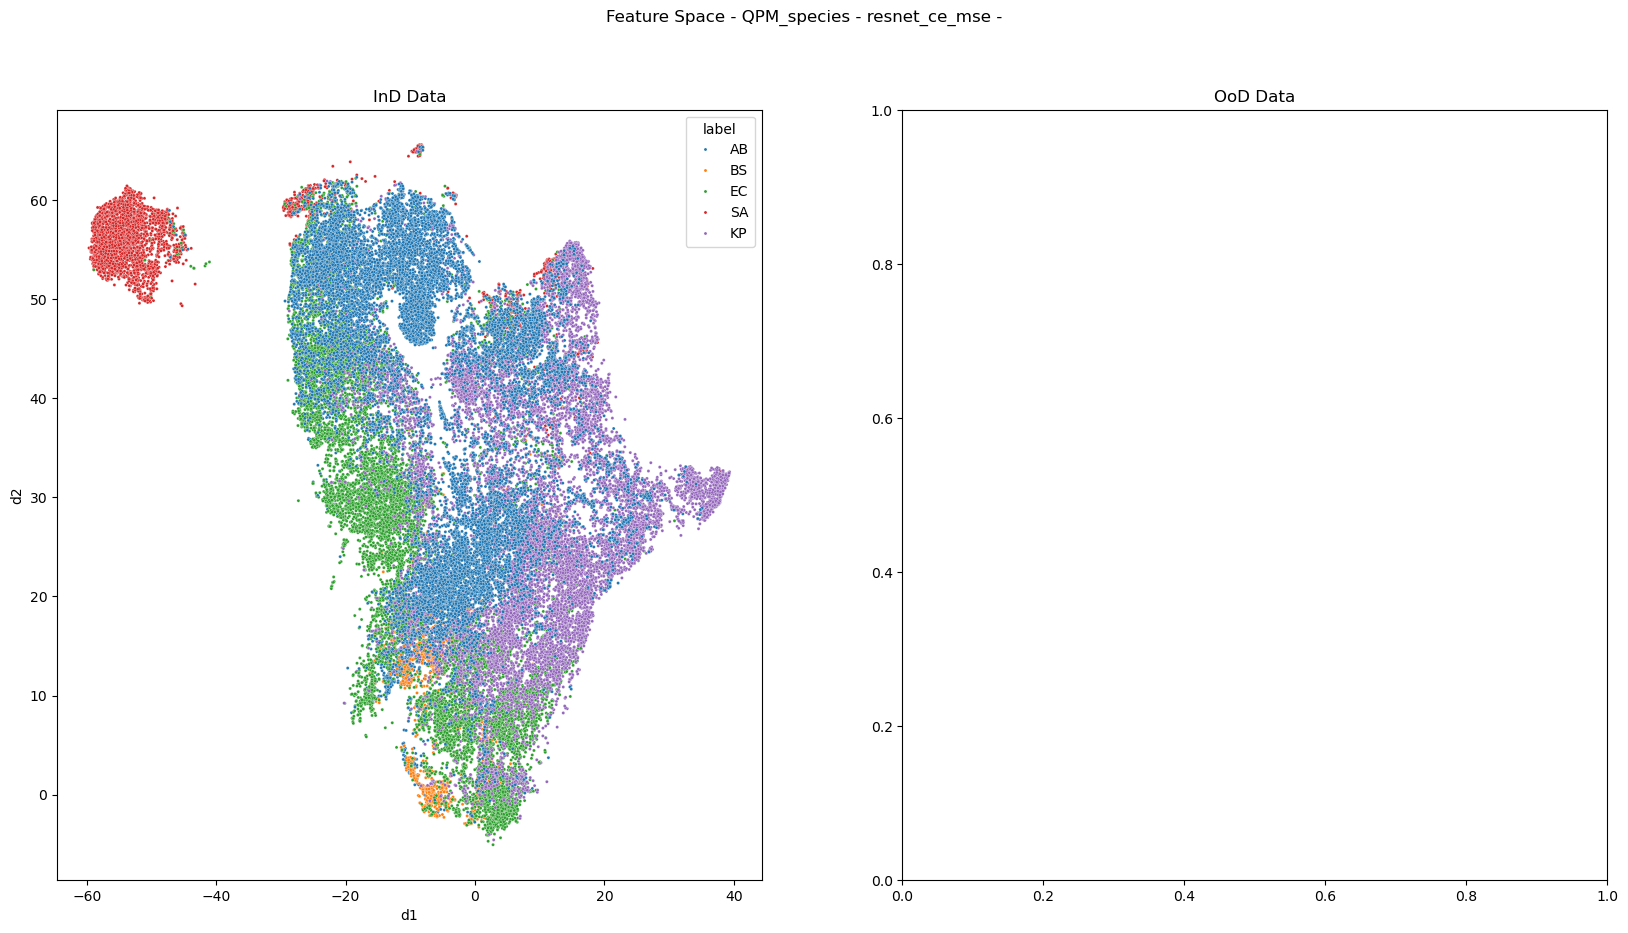

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

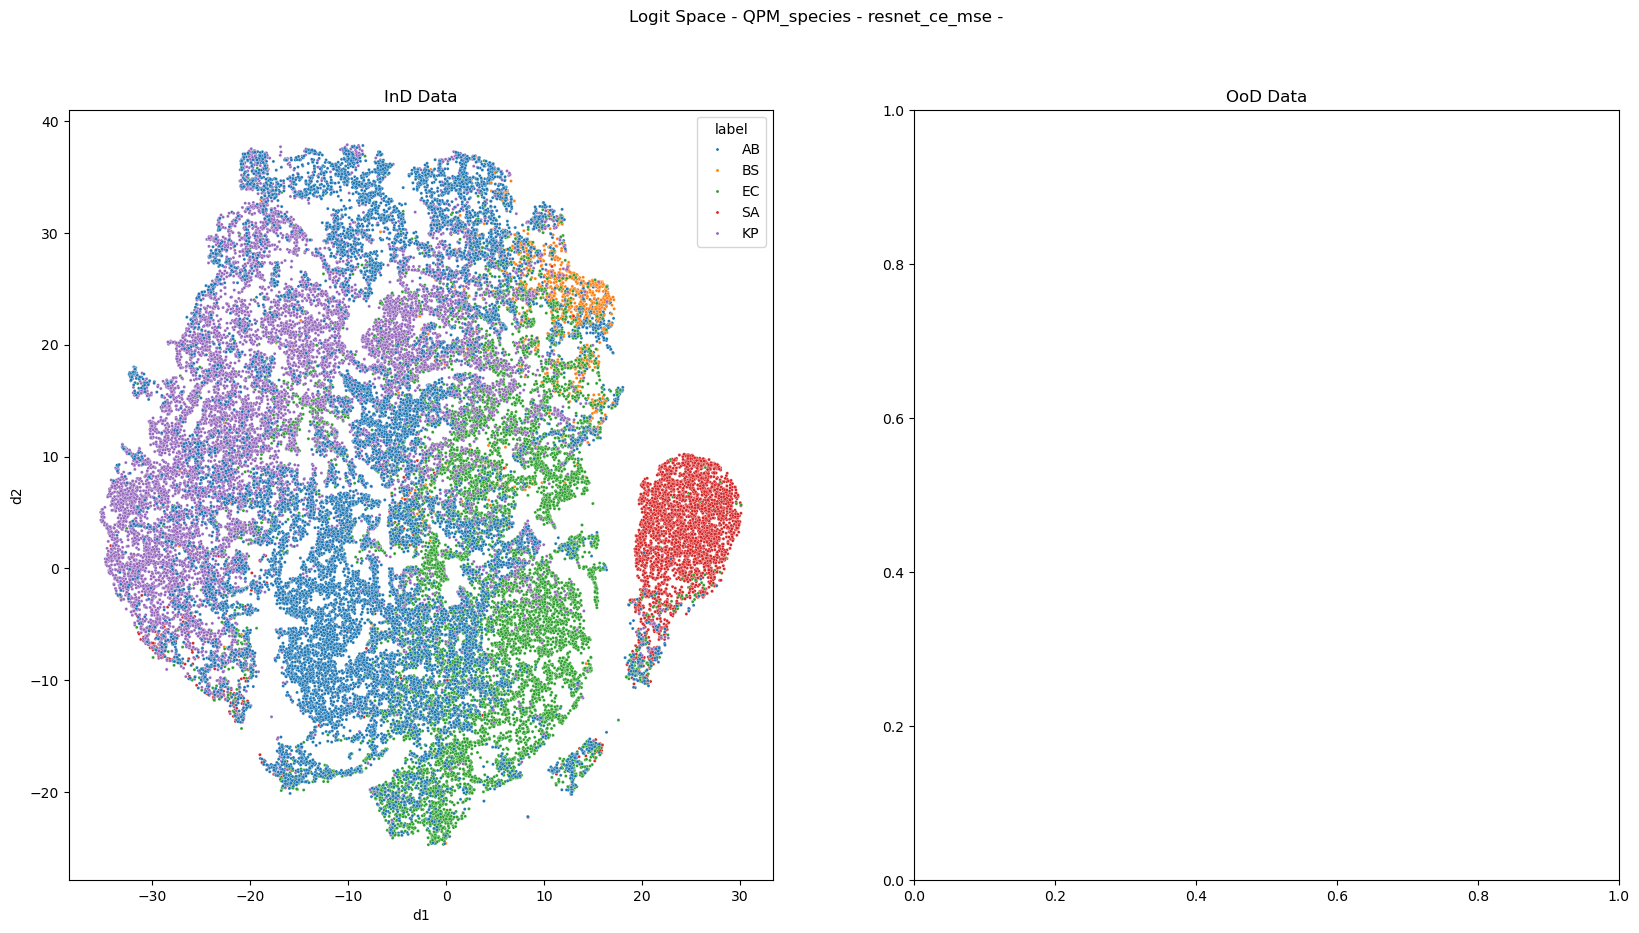

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:15<00:47, 15.88s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:31<00:31, 15.98s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:48<00:16, 16.09s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:04<00:00, 16.28s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:04<00:00, 16.18s/it]

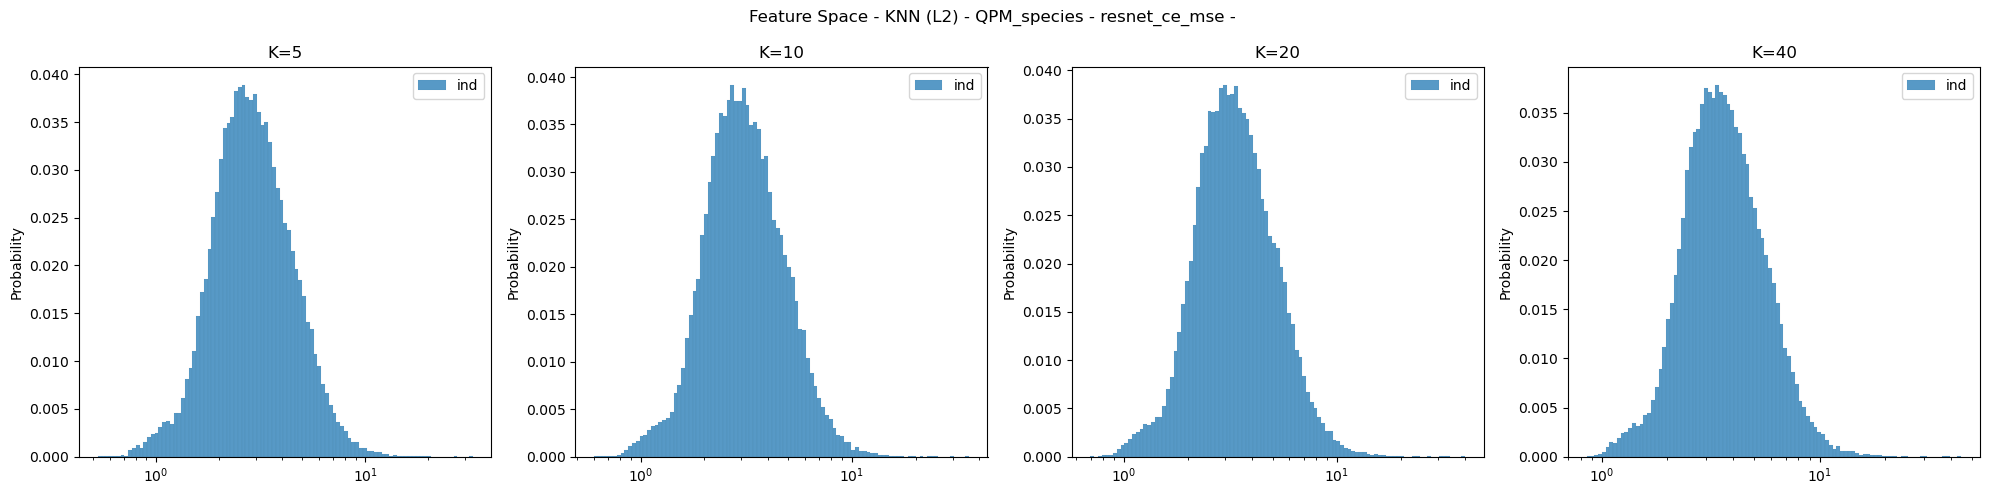

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:14<00:43, 14.56s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:29<00:29, 14.60s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:43<00:14, 14.64s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.83s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.75s/it]

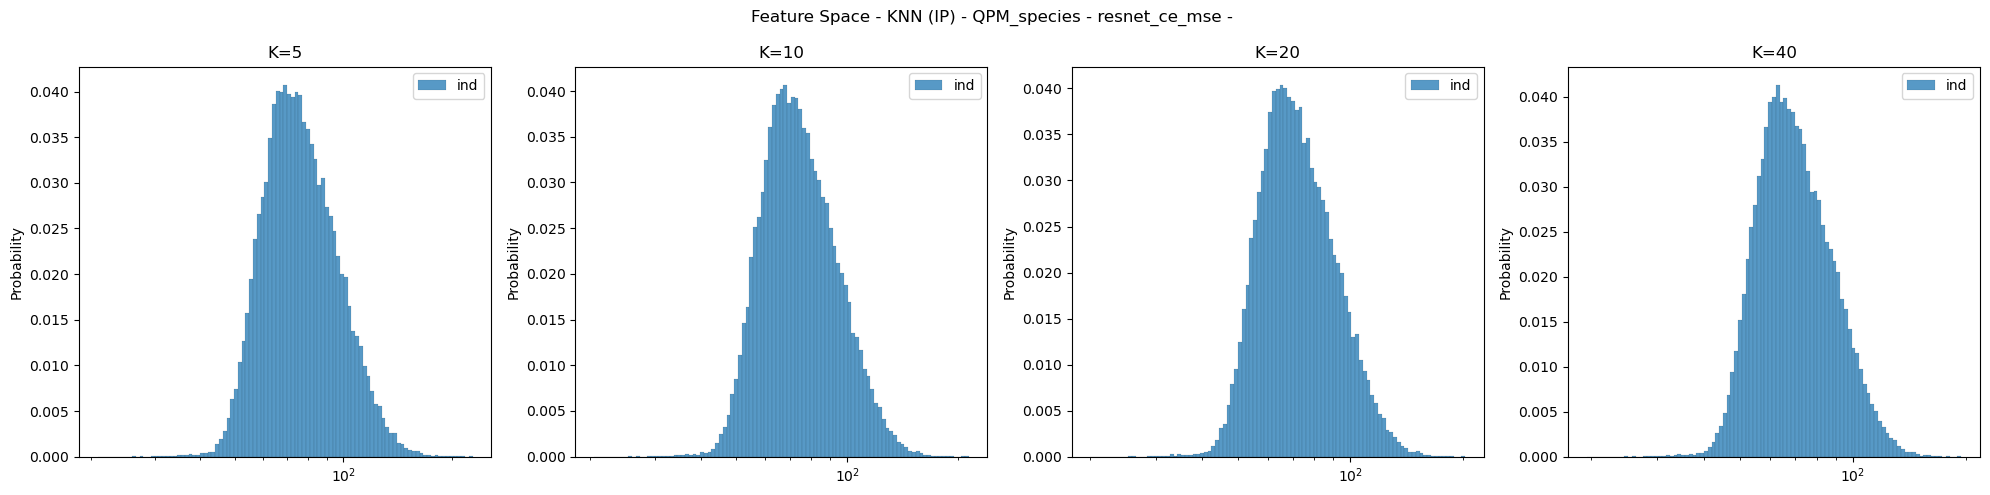

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:14<00:43, 14.60s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:29<00:29, 14.62s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:43<00:14, 14.68s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.82s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.75s/it]

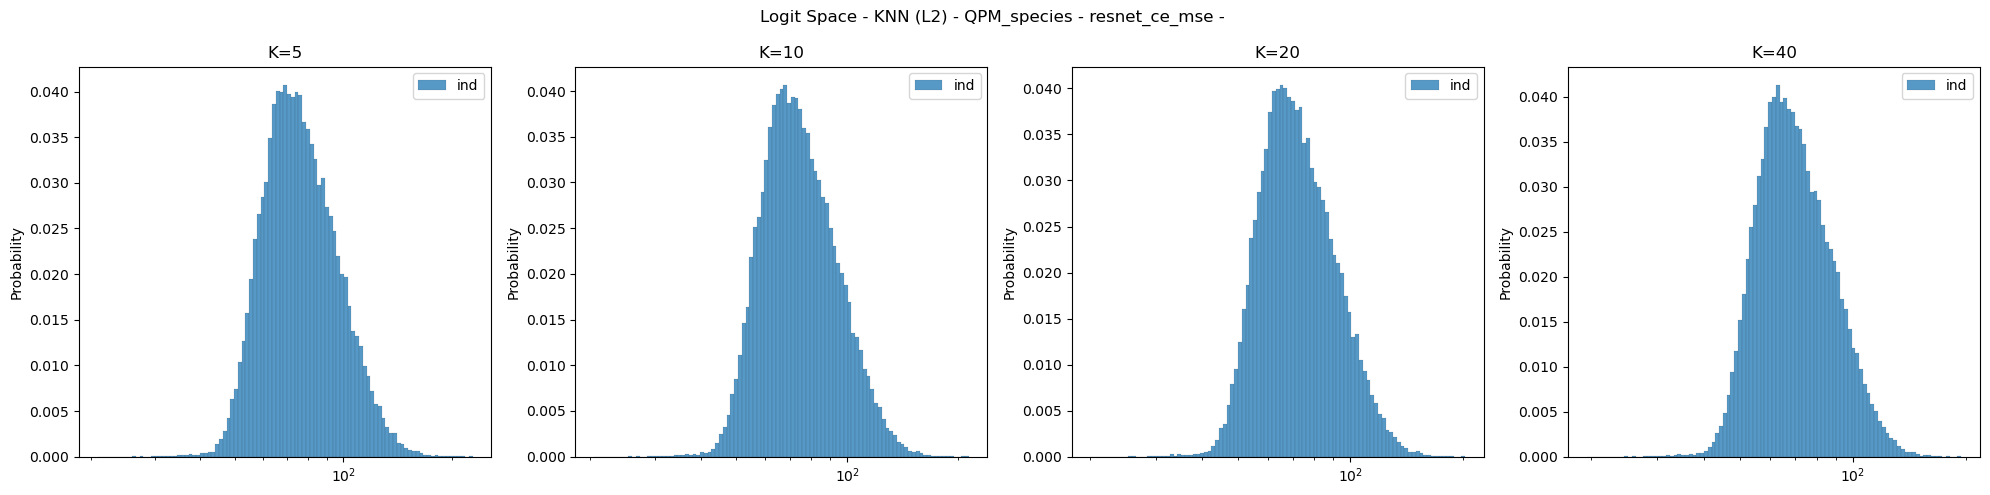

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:14<00:43, 14.54s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:29<00:29, 14.59s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:43<00:14, 14.64s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.78s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.72s/it]

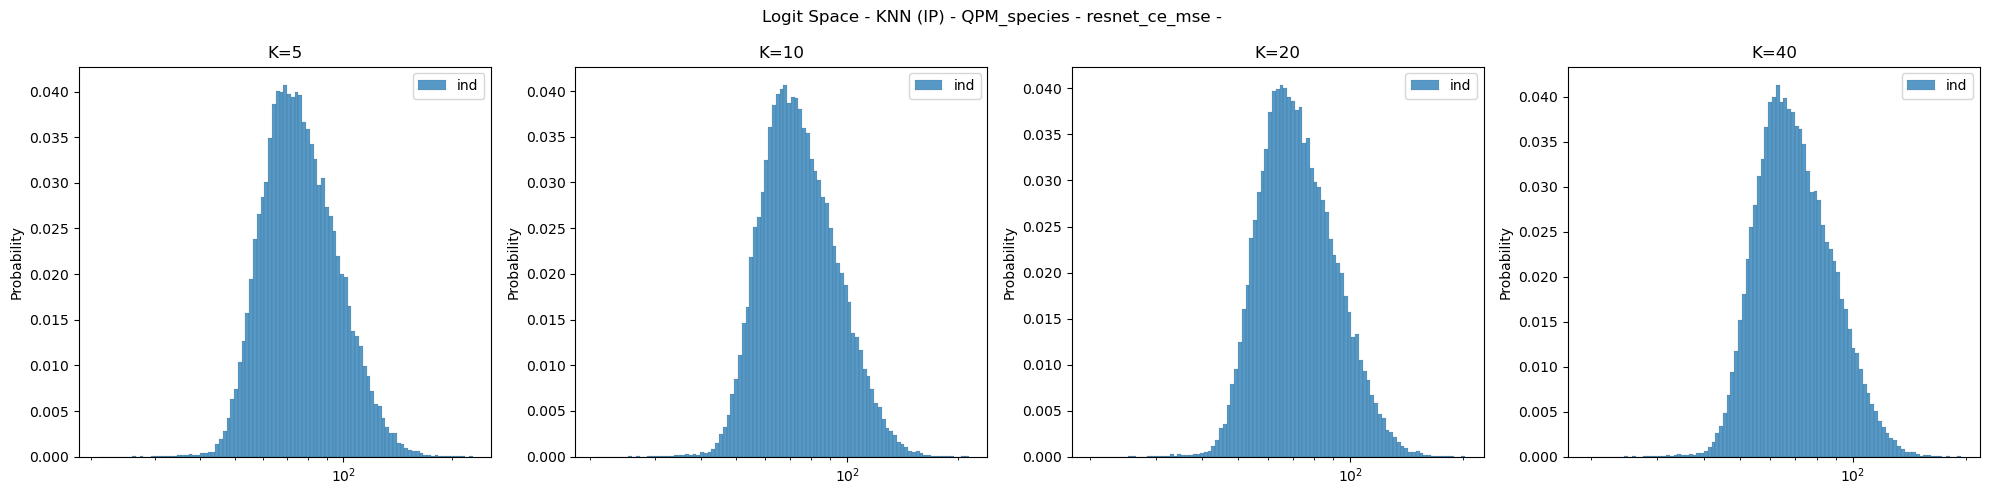

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

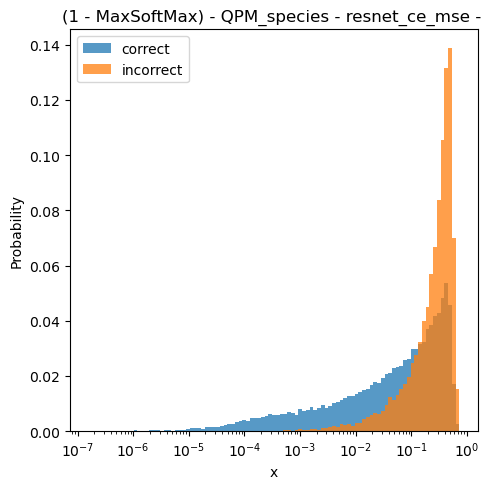

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()